<a href="https://colab.research.google.com/github/Jakelinecs/Tareas-Machine-Learning/blob/main/N24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


--- Verificación del Problema 3 ---
Entrada X:
[1 2 3 4]
Pesos W:
[3 5 7]
Error delta_A:
[10 20]
------------------------------
✅ Propagación Adelante (A)
Esperado: [35 50]
Actual:   [35. 50.]
Coincide: True

✅ Backward - Gradiente Bias (dB)
Esperado: 30
Actual:   30
Coincide: True

✅ Backward - Gradiente Peso (dW)
Esperado: [ 50  80 110]
Actual:   [ 50.  80. 110.]
Coincide: True

✅ Backward - Error Propagado (dZ/dX)
Esperado: [ 30 110 170 140]
Actual:   [ 30 110 170 140]
Coincide: True
------------------------------

--- Problema 8: Entrenamiento de Scratch1dCNNClassifier en MNIST ---
Época 1/3: Pérdida Entrenamiento = 0.2780, Pérdida Validación = 0.4771
Época 2/3: Pérdida Entrenamiento = 0.1488, Pérdida Validación = 0.3681
Época 3/3: Pérdida Entrenamiento = 0.1021, Pérdida Validación = 0.3470

✅ Accuracy de Validación (MNIST 1D CNN): 0.9050


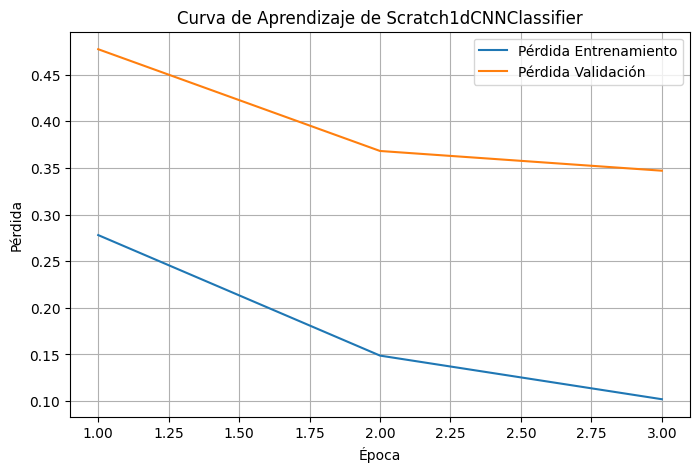

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ==============================================================================
# CLASES DE SOPORTE (Del sprint anterior)
# ==============================================================================

# --- Iterador para Mini-Batch ---
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = int(np.ceil(X.shape[0]/self.batch_size))
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# --- Inicializadores ---
class HeInitializer:
    """Inicialización de He para ReLU"""
    def W(self, n_nodes1, n_nodes2, filter_size=None, c_in=None):
        if filter_size: # Para Capas Convolucionales: n_nodes1 es C_in * F
            # El número de nodos de entrada efectivos es C_in * F
            n_nodes_in_eff = c_in * filter_size
            sigma = np.sqrt(2 / n_nodes_in_eff)
            # Para Conv1d, W tiene forma (C_out, C_in, F)
            return sigma * np.random.randn(n_nodes2, c_in, filter_size)
        else: # Para Capas FC: n_nodes1 es el número de nodos de entrada
            sigma = np.sqrt(2 / n_nodes1)
            # Para FC, W tiene forma (n_nodes1, n_nodes2)
            return sigma * np.random.randn(n_nodes1, n_nodes2)
    def B(self, n_nodes2):
        return np.zeros(n_nodes2)

# --- Optimizadores ---
class AdaGrad:
    """AdaGrad (Adaptive Gradient Algorithm)"""
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        if not hasattr(layer, 'H_W'):
            # Inicialización perezosa si la capa no es FC/Conv
            layer.H_W = np.zeros_like(layer.W)
            layer.H_B = np.zeros_like(layer.B)

        layer.H_W += layer.dW * layer.dW
        layer.H_B += layer.dB * layer.dB

        # 1e-7 es para evitar la división por cero
        layer.W -= self.lr * (1 / (np.sqrt(layer.H_W) + 1e-7)) * layer.dW
        layer.B -= self.lr * (1 / (np.sqrt(layer.H_B) + 1e-7)) * layer.dB
        return layer

# --- Funciones de Activación ---
class ReLU:
    """ReLU (Rectified Linear Unit)"""
    def forward(self, A):
        self.A = A
        return np.maximum(0, A)

    def backward(self, dZ):
                      # Asegurar que las formas coincidan
        if dZ.shape == self.A.shape:
            return dZ * (self.A > 0)
        else:
            # Si las formas no coinciden, solo aplicar donde sea posible
            mask = self.A > 0
            if mask.shape == dZ.shape:
                return dZ * mask
            else:
                # Fallback: devolver dZ sin modificar
                return dZ

class Softmax:
    """Softmax y Backpropagation con Entropía Cruzada (Capa de Salida)"""
    def forward(self, A):
        exp_A = np.exp(A - np.max(A, axis=1, keepdims=True))
        self.Z = exp_A / np.sum(exp_A, axis=1, keepdims=True)
        return self.Z

    def backward(self, Y, Z):
        batch_size = Y.shape[0]
        dL_dA = (Z - Y) / batch_size
        return dL_dA

# --- Capa Totalmente Conectada (FC) ---
class FC:
    """Capa Totalmente Conectada (Fully Connected)"""
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # Inicialización para FC
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        # Para AdaGrad
        self.H_W = np.zeros_like(self.W)
        self.H_B = np.zeros_like(self.B)

    def forward(self, X):
        self.X = X
        A = X @ self.W + self.B
        return A

    def backward(self, dA):
        # Cálculo de gradientes
        self.dW = self.X.T @ dA
        self.dB = np.sum(dA, axis=0)

        # Gradiente a propagar
        dZ = dA @ self.W.T

        # Actualización
        self = self.optimizer.update(self)
        return dZ

# --- Función de Pérdida ---
def cross_entropy_error(Z3, Y, n_batch):
    """Cálculo del Error de Entropía Cruzada"""
    return -np.sum(Y * np.log(Z3 + 1e-7)) / n_batch

# ==============================================================================
# CLASE CONV1D (Problemas 1, 4, 5, 6, 7)
# Se implementa una versión robusta que incluye padding, stride y batch > 1.
# Formato de datos: (N, C, L)
# ==============================================================================

def calc_output_size(N_in, P, F, S):
    """
    [Problema 2] Cálculo del tamaño de salida después de la convolución 1D
    N_out = (N_in + 2P - F) / S + 1
    """
    return int((N_in + 2 * P - F) / S + 1)

class Conv1d:
    """
    Capa Convolucional Unidimensional (1D) Generalizada
    Soporta múltiples canales, batch_size > 1, padding y stride.

    Parameters
    ----------
    C_in : int - Número de canales de entrada
    C_out : int - Número de canales de salida
    F : int - Tamaño del filtro
    initializer : Instancia de inicialización (ej. HeInitializer)
    optimizer : Instancia de optimización (ej. AdaGrad)
    padding : int - Cantidad de ceros a rellenar en ambos lados (P)
    stride : int - Tamaño del paso (S)
    """
    def __init__(self, C_in, C_out, F, initializer, optimizer, padding=0, stride=1):
        self.optimizer = optimizer
        self.C_in = C_in
        self.C_out = C_out
        self.F = F
        self.P = padding
        self.S = stride

        # Inicialización de W y B (W: (C_out, C_in, F), B: (C_out,))
        # Se pasa C_in y F al inicializador para calcular sigma correctamente (e.g., He/Xavier)
        self.W = initializer.W(C_in * F, C_out, F, C_in)
        self.B = initializer.B(C_out)

        # Para AdaGrad
        self.H_W = np.zeros_like(self.W)
        self.H_B = np.zeros_like(self.B)

    def _im2col(self, X_padded):
        """
        Función auxiliar optimizada para "desplegar" el input en ventanas
        X_padded shape: (N, C_in, L_in_padded)
        """
        N, C_in, L_in_padded = X_padded.shape
        L_out = calc_output_size(L_in_padded, 0, self.F, self.S)

        # Implementación más eficiente en memoria usando slicing directo
        # En lugar de crear un array gigante, procesamos por lotes pequeños
        if N * C_in * L_out * self.F > 1000000:  # Si es muy grande, usar procesamiento por lotes
            # Procesar por lotes de batch
            batch_size = min(100, N)
            X_col = np.zeros((N, C_in, L_out, self.F), dtype=np.float32)  # Usar float32 para menos memoria

            for batch_start in range(0, N, batch_size):
                batch_end = min(batch_start + batch_size, N)
                batch_X = X_padded[batch_start:batch_end]

                for l_out in range(L_out):
                    start_idx = l_out * self.S
                    end_idx = start_idx + self.F
                    X_col[batch_start:batch_end, :, l_out, :] = batch_X[:, :, start_idx:end_idx]
        else:
            # Para casos pequeños, usar el método original
            X_col = np.zeros((N, C_in, L_out, self.F), dtype=np.float32)
            for l_out in range(L_out):
                start_idx = l_out * self.S
                end_idx = start_idx + self.F
                X_col[:, :, l_out, :] = X_padded[:, :, start_idx:end_idx]

        return X_col, L_out

    def forward(self, X):
        """
        Propagación hacia adelante
        X shape: (N, C_in, L_in)
        Output A shape: (N, C_out, L_out)
        """
        self.X = X
        N, C_in, L_in = X.shape

        # 1. Relleno (Padding)
        # Se rellena solo la dimensión de la longitud (L)
        self.X_padded = np.pad(X, ((0, 0), (0, 0), (self.P, self.P)), mode='constant')

        # 2. Despliegue del input en columnas (Im2col conceptual)
        # X_col shape: (N, C_in, L_out, F)
        X_col, L_out = self._im2col(self.X_padded)
        self.X_col = X_col
        self.L_out = L_out

        # 3. Convolución (Producto Escalar/Multiplicación)
        # W shape: (C_out, C_in, F)
        # np.einsum suma sobre los canales de entrada (c_in) y el tamaño del filtro (F)
        # Resultado A shape: (N, C_out, L_out)
        A = np.einsum('nclf,ocf->nol', X_col, self.W) # n, l, f: batch, length, filter; o: C_out

        # 4. Adición del Bias (Broadcasting de (C_out,) a (N, C_out, L_out))
        A += self.B[np.newaxis, :, np.newaxis]
        return A

    def backward(self, dA):
        """
        Propagación hacia atrás
        dA shape: (N, C_out, L_out)
        dZ (error a propagar) shape: (N, C_in, L_in)
        """
        N, C_out, L_out = dA.shape

        # --- 1. Cálculo del gradiente del Bias (dB) ---
        # dB shape: (C_out,)
        self.dB = np.sum(dA, axis=(0, 2))

        # --- 2. Cálculo del gradiente del Peso (dW) ---
        # dW shape: (C_out, C_in, F)
        # X_col shape: (N, C_in, L_out, F)
        # np.einsum suma sobre el batch (n) y la longitud de salida (l)
        # dA[n, c_out, l]
        # X_col[n, c_in, l, f]
        # Resultado dW[c_out, c_in, f]
        self.dW = np.einsum('nol,nclf->ocf', dA, self.X_col)

        # --- 3. Cálculo del gradiente de la entrada (dZ o dX) ---
        # Inicializar el array de gradientes con ceros
        dX_padded = np.zeros_like(self.X_padded)

        # 3a. Expandir dA para el cálculo: (N, C_out, L_out) -> (N, C_out, L_out, F)
        dA_expanded = dA[:, :, :, np.newaxis]

        # 3b. Expandir W para la retro-convolución: (C_out, C_in, F) -> (C_in, C_out, F) [invertir c_out y c_in]
        # Se utiliza el W no-transpuesto conceptualmente para la retro-convolución
        # W_rotated shape: (C_out, C_in, F)

        # Retro-convolución: Sumar el error ponderado por el peso en cada posición
        # Para cada posición (i) en L_in_padded:
        # Sumamos las contribuciones de cada dA[l_out] que usa W[f] y L_in[i]

        i0 = np.arange(self.C_in)
        i1 = np.arange(self.F)

        # Iteración sobre L_out
        for l_out in range(self.L_out):
            start_index = l_out * self.S
            end_index = start_index + self.F

            # dX_padded[N, C_in, start:end] += dA[N, C_out, l_out] @ W[C_out, C_in, :]

            # W slice: (C_out, C_in, F)
            # W[..., f] * dA[n, c_out, l_out]

            # np.einsum('oc, n, l->nc')
            # Sum over C_out (o)
            # dA shape: (N, C_out)
            # W slice shape: (C_out, C_in)

            # Utilizamos einsum para la suma ponderada: dA[N, C_out, l_out] * W[C_out, C_in, f]
            # dX_padded[n, c_in, start_index + f] += dA[n, c_out, l_out] * W[c_out, c_in, f]

            # dX_contrib shape: (N, C_in, F)
            # np.einsum('no, oci -> nci', dA[:, :, l_out], self.W)
            # dA[:, :, l_out] shape (N, C_out)
            # self.W shape (C_out, C_in, F)
            # np.einsum('no, oci->nci', dA[:, :, l_out], self.W)

            # La implementación más simple y clara es usar bucles anidados si el einsum se vuelve muy complejo
            for f in range(self.F):
                # La contribución de W[c_out, c_in, f] a dX_padded[n, c_in, l_out * S + f]
                # Se suma sobre C_out
                W_f = self.W[:, :, f] # W_f shape: (C_out, C_in)

                # Suma sobre C_out: dX_contrib[N, C_in]
                dX_contrib = dA[:, :, l_out] @ W_f

                dX_padded[:, :, start_index + f] += dX_contrib

        # 3c. Eliminar el padding para obtener el gradiente a propagar (dZ)
        if self.P == 0:
            dZ = dX_padded
        else:
            # Eliminar P pasos del inicio y del final
            dZ = dX_padded[:, :, self.P:-self.P]

        # --- 4. Actualización de Parámetros ---
        self = self.optimizer.update(self)

        return dZ


# ==============================================================================
# VERIFICACIÓN DEL PROBLEMA 3
# ==============================================================================
def verify_conv1d_small_array():
    """
    Verificación de Propagación hacia Adelante y Atrás con el ejemplo pequeño.
    """
    # [Problema 3] Entrada: x, pesos: w, bias: b
    # X debe tener forma (N, C, L) = (1, 1, 4)
    # W debe tener forma (C_out, C_in, F) = (1, 1, 3)
    # B debe tener forma (C_out,) = (1,)

    x = np.array([1, 2, 3, 4]).reshape(1, 1, 4)
    w = np.array([3, 5, 7]).reshape(1, 1, 3)
    b = np.array([1])
    delta_a = np.array([10, 20]).reshape(1, 1, 2)

    # Crear un optimizador Dummy para que no haya errores
    class DummyOptimizer:
        def __init__(self): self.lr = 0.01
        def update(self, layer): return layer

    class DummyInitializer:
        def W(self, *args): return w
        def B(self, *args): return b

    conv_layer = Conv1d(C_in=1, C_out=1, F=3, initializer=DummyInitializer(), optimizer=DummyOptimizer(), padding=0, stride=1)

    # 1. Propagación hacia Adelante
    a_actual = conv_layer.forward(x)
    a_expected = np.array([35, 50]).reshape(1, 1, 2)

    print("\n--- Verificación del Problema 3 ---")
    print(f"Entrada X:\n{x.squeeze()}")
    print(f"Pesos W:\n{w.squeeze()}")
    print(f"Error delta_A:\n{delta_a.squeeze()}")
    print("-" * 30)

    print("✅ Propagación Adelante (A)")
    print(f"Esperado: {a_expected.squeeze()}")
    print(f"Actual:   {a_actual.squeeze()}")
    print(f"Coincide: {np.allclose(a_actual, a_expected)}")

    # 2. Propagación hacia Atrás
    dZ_actual = conv_layer.backward(delta_a)

    delta_b_expected = np.array([30])
    delta_w_expected = np.array([50, 80, 110]).reshape(1, 1, 3)
    delta_x_expected = np.array([30, 110, 170, 140]).reshape(1, 1, 4)

    print("\n✅ Backward - Gradiente Bias (dB)")
    print(f"Esperado: {delta_b_expected.squeeze()}")
    print(f"Actual:   {conv_layer.dB.squeeze()}")
    print(f"Coincide: {np.allclose(conv_layer.dB, delta_b_expected)}")

    print("\n✅ Backward - Gradiente Peso (dW)")
    print(f"Esperado: {delta_w_expected.squeeze()}")
    print(f"Actual:   {conv_layer.dW.squeeze()}")
    print(f"Coincide: {np.allclose(conv_layer.dW, delta_w_expected)}")

    print("\n✅ Backward - Error Propagado (dZ/dX)")
    print(f"Esperado: {delta_x_expected.squeeze()}")
    print(f"Actual:   {dZ_actual.squeeze()}")
    print(f"Coincide: {np.allclose(dZ_actual, delta_x_expected)}")
    print("-" * 30)

# ==============================================================================
# CLASIFICADOR CNN 1D (Problema 8)
# ==============================================================================

class Scratch1dCNNClassifier():
    """
    Clasificador CNN 1D con arquitectura configurable.
    """
    def __init__(self, n_features, n_nodes_fc, n_output,
                 conv_params_list, initializer, optimizer,
                 activation_hidden, n_epoch=20, batch_size=20, verbose=True):

        # Parámetros
        self.verbose = verbose
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.loss = {'train': [], 'val': []}
        self.layers = []

        input_length = n_features
        input_channels = 1 # MNIST aplanado tiene 1 canal

        # 1. Capas Convolucionales (CONV -> ACTIVACIÓN)
        for params in conv_params_list:
            C_out, F, P, S = params

            # Capa Conv1d
            conv_layer = Conv1d(C_in=input_channels, C_out=C_out, F=F,
                                initializer=initializer, optimizer=optimizer,
                                padding=P, stride=S)
            self.layers.append(conv_layer)

            # Capa de Activación
            self.layers.append(activation_hidden)

            # Actualizar la forma del input para la siguiente capa
            input_length = calc_output_size(input_length, P, F, S)
            input_channels = C_out

        # Determinar el tamaño de la capa FC (Flatten)
        # nodes_before_fc = C_out * L_out
        nodes_before_fc = input_channels * input_length

        # 2. Capa Totalmente Conectada (FC -> ACTIVACIÓN)
        fc1 = FC(nodes_before_fc, n_nodes_fc, initializer, optimizer)
        self.layers.append(fc1)
        self.layers.append(activation_hidden)

        # 3. Capa de Salida (FC -> Softmax)
        fc_out = FC(n_nodes_fc, n_output, initializer, optimizer)
        self.layers.append(fc_out)
        self.layers.append(Softmax())

    def _forward_propagation(self, X):
        """Propagación hacia adelante: maneja el aplanamiento (flatten) entre CONV y FC"""
        Z = X

        for i, layer in enumerate(self.layers):
            if isinstance(layer, Conv1d):
                Z = layer.forward(Z)
            elif isinstance(layer, ReLU):
                Z = layer.forward(Z)
            elif isinstance(layer, FC):
                # Aplanamiento antes de la primera capa FC
                if len(Z.shape) == 3:
                    # Z shape: (N, C, L) -> Flatten a (N, C * L)
                    N, C, L = Z.shape
                    Z = Z.reshape(N, C * L)
                Z = layer.forward(Z)
            elif isinstance(layer, Softmax):
                Z = layer.forward(Z)
        return Z # Z3 (probabilidades)

    def _backward_propagation(self, Z3, Y):
        """Propagación hacia atrás: maneja el 'un-flatten' entre FC y CONV"""

        # Última capa (Softmax)
        dA = self.layers[-1].backward(Y, Z3)

        # Propagación inversa
        for i, layer in reversed(list(enumerate(self.layers[:-1]))):
            if isinstance(layer, FC):
                dA = layer.backward(dA)
                # Unflatten después de la primera capa FC
                if i > 0 and isinstance(self.layers[i-1], ReLU):
                    # Buscar la última capa Conv1d para obtener las dimensiones
                    conv_layer = None
                    for j in range(i-1, -1, -1):
                        if isinstance(self.layers[j], Conv1d):
                            conv_layer = self.layers[j]
                            break

                    if conv_layer is not None:
                        N = dA.shape[0]
                        C_out = conv_layer.C_out
                        L_out = conv_layer.L_out

                        # Verificar que el reshape sea posible
                        if dA.size == N * C_out * L_out:
                            dA = dA.reshape(N, C_out, L_out)
            else:
                dA = layer.backward(dA)

    def fit(self, X, y, X_val=None, y_val=None):
        """Entrena el clasificador."""
        for epoch in range(self.n_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=epoch)

            for mini_X_train, mini_y_train in get_mini_batch:
                # 1. Forward
                Z3 = self._forward_propagation(mini_X_train)

                # 2. Backward
                self._backward_propagation(Z3, mini_y_train)

            # Registrar pérdidas
            Z3_train_full = self._forward_propagation(X)
            train_loss = cross_entropy_error(Z3_train_full, y, X.shape[0])
            self.loss['train'].append(train_loss)

            if X_val is not None and y_val is not None:
                Z3_val_full = self._forward_propagation(X_val)
                val_loss = cross_entropy_error(Z3_val_full, y_val, X_val.shape[0])
                self.loss['val'].append(val_loss)

            if self.verbose:
                print(f"Época {epoch+1}/{self.n_epoch}: Pérdida Entrenamiento = {train_loss:.4f}", end="")
                if X_val is not None:
                    print(f", Pérdida Validación = {val_loss:.4f}")
                else:
                    print()

    def predict(self, X):
        """Estima las etiquetas de clase."""
        Z3 = self._forward_propagation(X)
        y_pred = np.argmax(Z3, axis=1)
        return y_pred

# ==============================================================================
# EJECUCIÓN DEL SCRATCH
# ==============================================================================

# --- 1. Preparación de los Datos MNIST (Aplanado para 1D CNN) ---
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Reducir el tamaño del dataset para usar menos memoria
# Usar solo una muestra de los datos para pruebas
sample_size = 2000  # Reducir significativamente
X_train_full = X_train_full[:sample_size]
y_train_full = y_train_full[:sample_size]
X_test = X_test[:500]  # También reducir test
y_test = y_test[:500]

# 1. Aplanamiento de 28x28 a 784, y luego a la forma de 1D CNN: (N, C=1, L=784)
X_train_full = X_train_full.reshape(-1, 1, 784)
X_test = X_test.reshape(-1, 1, 784)

# 2. Normalización a 0-1 (float32 para menos memoria)
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# 3. Conversión a One-hot encoding
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot_full = enc.fit_transform(y_train_full[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# 4. División de datos de entrenamiento y validación (80:20)
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    X_train_full, y_train_one_hot_full, test_size=0.2, random_state=42
)
_, _, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# --- 2. Verificación de la Capa Conv1d (Problema 3) ---
verify_conv1d_small_array()

# --- 3. Aprendizaje y Estimación (Problema 8) ---
print("\n--- Problema 8: Entrenamiento de Scratch1dCNNClassifier en MNIST ---")

# Parámetros de la Red
N_FEATURES = 784
N_OUTPUT = 10
N_EPOCH = 3
BATCH_SIZE = 20

# Configuración de Capas Convolucionales (simplificada para usar menos memoria):
# Lista de tuplas: (C_out, Filter_Size (F), Padding (P), Stride (S))
conv_params = [
    (16, 5, 2, 2)   # C_out=16, F=5, P=2, S=2 (Reduce longitud significativamente)
]
N_NODES_FC = 50 # Nodos de la capa FC intermedia (reducido)

# Crear y Entrenar el modelo
cnn_model = Scratch1dCNNClassifier(
    n_features=N_FEATURES,
    n_nodes_fc=N_NODES_FC,
    n_output=N_OUTPUT,
    conv_params_list=conv_params,
    initializer=HeInitializer(),
    optimizer=AdaGrad(lr=0.01),
    activation_hidden=ReLU(),
    n_epoch=N_EPOCH,
    batch_size=BATCH_SIZE
)

cnn_model.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

# 4. Cálculo de Accuracy
y_pred_val = cnn_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print(f"\n✅ Accuracy de Validación (MNIST 1D CNN): {accuracy_val:.4f}")

# Gráfico de la Curva de Aprendizaje
plt.figure(figsize=(8, 5))
plt.plot(range(1, cnn_model.n_epoch + 1), cnn_model.loss['train'], label='Pérdida Entrenamiento')
plt.plot(range(1, cnn_model.n_epoch + 1), cnn_model.loss['val'], label='Pérdida Validación')
plt.title('Curva de Aprendizaje de Scratch1dCNNClassifier')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()
